In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def get_color_code(color, percentile):
    cmap = plt.get_cmap(color) 
    position = percentile / 100
    rgba_color = cmap(position)
    # Convert RGBA to RGB (since A is the alpha channel)
    rgb_color = rgba_color[:3]  # Exclude the alpha value
    # Convert RGB to hexadecimal color code
    hex_color = mcolors.rgb2hex(rgb_color)
    return hex_color

num_heavy_atom = 9
num_iterations = 200

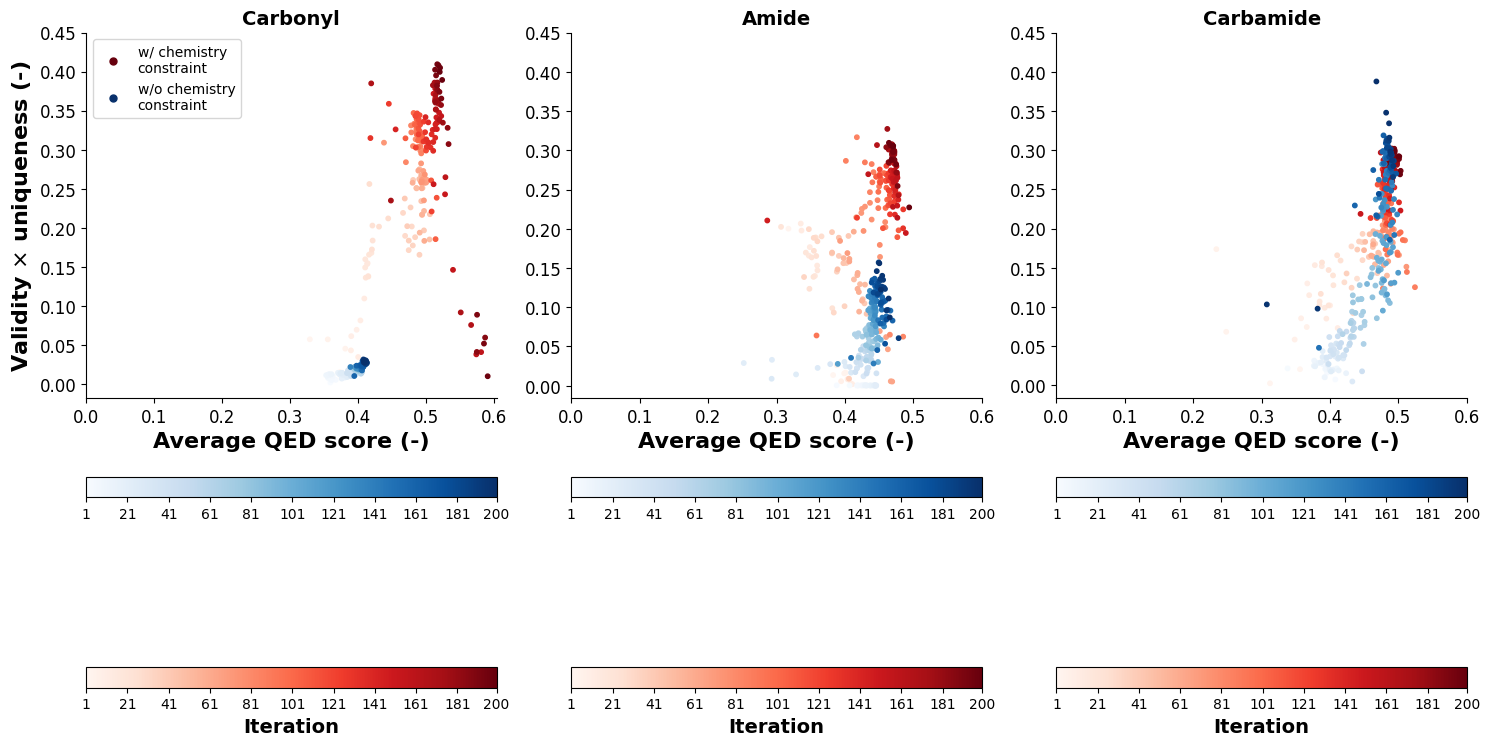

In [2]:
# Define functional groups to plot
functional_groups = ["carbonyl", "amide", "carbamide"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 8), dpi=100)

for i, functional_group in enumerate(functional_groups):
    ax = axes[i]  # Get the current subplot axis
    
    # File paths
    data_path_chem = f"../results_chemistry_constraint_bo/{functional_group}_{num_heavy_atom}_chem_1.csv"
    data_path_no_chem = f"../results_no_chemistry_constraint_bo/{functional_group}_{num_heavy_atom}_no_chem_1.csv"
    
    # Read data
    trial_df_chem = pd.read_csv(data_path_chem)
    trial_df_chem['trial_index'] = trial_df_chem['trial_index'] - 4
    trial_df_chem = trial_df_chem.iloc[5:num_iterations+5]
    
    trial_df_no_chem = pd.read_csv(data_path_no_chem)
    trial_df_no_chem['trial_index'] = trial_df_no_chem['trial_index'] - 4
    trial_df_no_chem = trial_df_no_chem.iloc[5:num_iterations+5]
    
    # Scatter plot with color based on 'trial_index' column
    scatter_chem = ax.scatter(trial_df_chem['qed'], trial_df_chem['product_validity_uniqueness'], c=trial_df_chem['trial_index'], 
                              cmap='Reds', s=10, label="w/ chemistry\nconstraint")
    scatter_no_chem = ax.scatter(trial_df_no_chem['qed'], trial_df_no_chem['product_validity_uniqueness'], c=trial_df_no_chem['trial_index'], 
                                 cmap='Blues', s=10, label="w/o chemistry\nconstraint")
    
    # Adding colorbar with integer ticks
    z_min, z_max = int(trial_df_chem['trial_index'].min()), int(trial_df_chem['trial_index'].max())
    colorbar_1 = fig.colorbar(scatter_chem, ax=ax, ticks=list(np.arange(z_min, z_max + 1, 20))+[200], orientation='horizontal')
    colorbar_2 = plt.colorbar(scatter_no_chem, ticks=list(np.arange(z_min, z_max + 1, 20))+[200], orientation='horizontal')
    colorbar_1.set_label('Iteration', fontsize=14, weight='semibold')
    
    # Legend with proxy artists
    red_proxy = mlines.Line2D([], [], color=get_color_code("Reds", num_iterations / 2), marker='.', linestyle='None', markersize=10, label="w/ chemistry\nconstraint")
    blue_proxy = mlines.Line2D([], [], color=get_color_code("Blues", num_iterations / 2), marker='.', linestyle='None', markersize=10, label="w/o chemistry\nconstraint")
    if i == 0:
        ax.legend(handles=[red_proxy, blue_proxy], loc="upper left")
    
    # Set labels with appropriate font sizes
    ax.set_xlabel('Average QED score (-)', fontsize=16, weight='semibold')
    if i == 0:
        ax.set_ylabel("Validity $\\times$ uniqueness (-)", fontsize=16, weight='semibold')
    else:
        ax.set_ylabel(None)
    
    # Adjust tick parameters
    ax.set_xticks(np.arange(0, 0.7, 0.1))
    ax.set_yticks(np.arange(0, 0.5, 0.05))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set the title for each subplot based on functional group
    ax.set_title(f"{functional_group.capitalize()}", fontsize=14, weight='semibold')

# Tight layout for optimal spacing
plt.tight_layout()
plt.savefig("figures/mpo.svg", format="svg")
plt.show()

In [3]:
import pickle
# functional_group_index = {"carbonyl": {"before_index":0, "after_index_chem":54, "after_index_no_chem": 54},
#                           "carbamide": {"before_index":0, "after_index_chem":47, "after_index_no_chem": 53},
#                           "amide": {"before_index":0, "after_index_chem":53, "after_index_no_chem": 54}
#                           }
functional_group_index = {"carbonyl": {"before_index":0, "after_index_chem":200, "after_index_no_chem": 200},
                          "carbamide": {"before_index":0, "after_index_chem":200, "after_index_no_chem": 200},
                          "amide": {"before_index":0, "after_index_chem":200, "after_index_no_chem": 200}
                          }

functional_group_distribution_list = []
for functional_group in functional_groups:
    sub_list = []
    for index_name in ["before_index", "after_index_no_chem", "after_index_chem"]:
        index = functional_group_index[functional_group][index_name]
        if index_name in ["before_index", "after_index_no_chem"]:
            file_name = f"../results_no_chemistry_constraint_bo/sample_{functional_group}_{num_heavy_atom}_no_chem_1_{index}.pkl"
        else:
            file_name = f"../results_chemistry_constraint_bo/sample_{functional_group}_{num_heavy_atom}_chem_1_{index}.pkl"
        with open(file_name, "rb") as f:
            data = pickle.load(f)
        sub_list.append(data)
    functional_group_distribution_list.append(sub_list)

In [4]:
import sys
sys.path.append("../")
from qmg.generator import MoleculeGenerator
from qmg.utils import ConditionalWeightsGenerator, FitnessCalculator

fitness_distribution_list = []
fc = FitnessCalculator(task="qed")

for i in range(len(functional_group_distribution_list)):
    sub_list = []
    for j in range(len(functional_group_distribution_list[0])):
        smiles_dict = functional_group_distribution_list[i][j]
        data_distribution = fc.generate_property_distribution(smiles_dict)
        sub_list.append(data_distribution)
    fitness_distribution_list.append(sub_list)

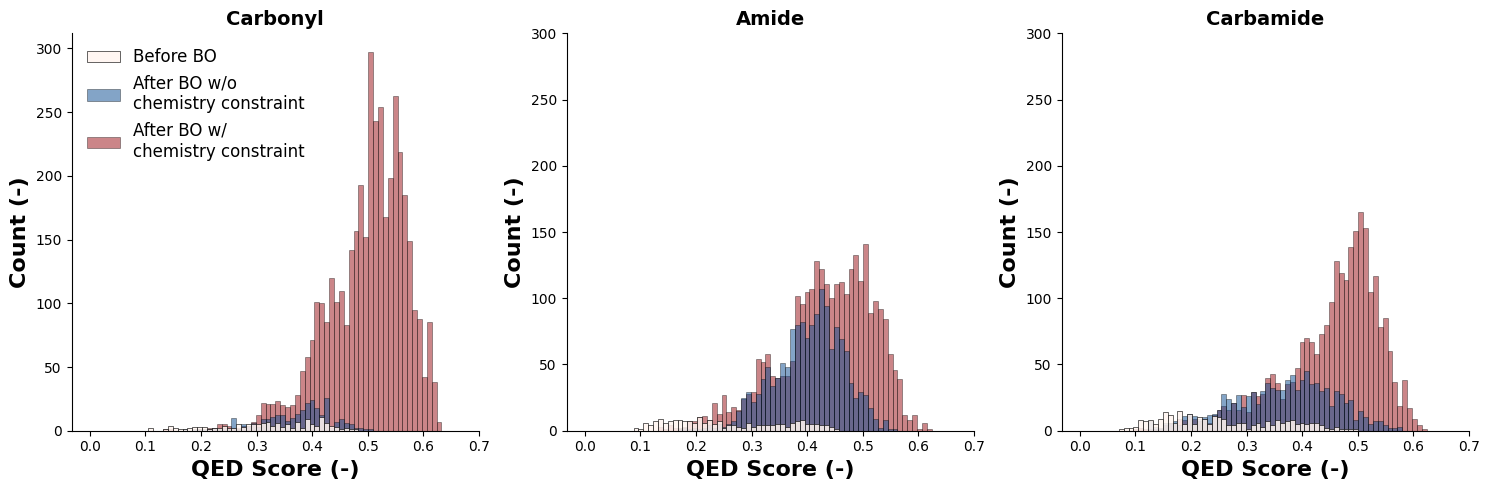

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def get_color_code(color, percentile):
    cmap = plt.get_cmap(color)
    position = percentile / 100
    rgba_color = cmap(position)
    rgb_color = rgba_color[:3]  # Exclude the alpha value
    hex_color = mcolors.rgb2hex(rgb_color)
    return hex_color

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
bins = np.linspace(0, 0.65, 75)

for i, functional_group in enumerate(functional_groups):
    ax = axes[i]  # Select the subplot axis
    
    # Plot histograms with adjusted styles for each subplot
    
    ax.hist(
        fitness_distribution_list[i][2],
        bins=bins,
        color=get_color_code("Reds", 90), 
        edgecolor='black',
        linewidth=0.5,
        alpha=0.5,
        label='After BO w/\nchemistry constraint'
    )
    ax.hist(
        fitness_distribution_list[i][1],
        bins=bins,
        color=get_color_code("Blues", 90), 
        edgecolor='black',
        linewidth=0.5,
        alpha=0.5,
        label='After BO w/o\nchemistry constraint'
    )
    ax.hist(
        fitness_distribution_list[i][0],
        bins=bins,
        color=get_color_code("Reds", 0),
        edgecolor='black',
        linewidth=0.5,
        alpha=0.85,
        label='Before BO'
    )
    # Label axes
    ax.set_xlabel('QED Score (-)', fontsize=16, weight='semibold')
    ax.set_ylabel('Count (-)', fontsize=16, weight='semibold')
    ax.set_xticks(np.arange(0, 0.8, 0.1))
    ax.set_yticks(np.arange(0, 320, 50))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    if i == 0:
        # Get the current handles and labels from the plot
        handles, labels = ax.get_legend_handles_labels()
        # Reorder the handles and labels (e.g., if you want to swap the first and last labels)
        order = [2, 1, 0]  # Specify the new order of labels
        ax.legend([handles[i] for i in order], [labels[i] for i in order], frameon=False, fontsize=12, loc="upper left")


    # Set the title for each subplot
    ax.set_title(f"{functional_group.capitalize()}", fontsize=14, weight='semibold')

# Adjust layout to prevent clipping
plt.tight_layout()
# Save the figure in a vector format (optional)
plt.savefig('figures/propery_distribution.svg', format='svg')
plt.show()


In [13]:
for i, functional_group in enumerate(functional_groups):
    print(i, functional_group)
    for j in range(len(functional_group_distribution_list[0])):
        if j == 0:
            continue
        if j == 1:
            print("After BO w/o chemistry constraint")
        if j == 2:
            print("After BO w/ chemistry constraint")
        smiles_dict = functional_group_distribution_list[i][j]
        prop_dict = fc.generate_property_dict(smiles_dict)
        top_10 = dict(sorted(prop_dict.items(), key=lambda item: item[1], reverse=True)[:10])
        print(top_10)

0 carbonyl
After BO w/o chemistry constraint


{'C=CCC(=O)O': 0.5006970737992, 'C=CC1=CC(=O)N1': 0.4944206116502758, 'CCC(=O)O': 0.4908446664452932, 'C=CNC(C)=O': 0.48605367287207835, 'C=Cc1cc1=O': 0.4815179071694712, 'C=CC1=CC(=O)C1': 0.47469529660525783, 'C=NCC(=O)O': 0.4728189142118678, 'C=CCC(N)=O': 0.47278472146091227, 'O=C(O)C1=C=N1': 0.47017074327751535, 'C=CC(=O)CO': 0.4696852142405516}
After BO w/ chemistry constraint
{'CC[C@H](C)[C@@H](C)C(=O)O': 0.6315729529430132, 'CCC[C@H](C)CC(=O)O': 0.6306362992241078, 'CCC[C@H](CC)C(=O)O': 0.6306362992241078, 'CCC[C@@H](CC)C(=O)O': 0.6306362992241078, 'CCCC[C@H](C)C(=O)O': 0.6306362992241077, 'CC[C@@H]1C[C@@H]1CC(=O)O': 0.6250858180201716, 'CC[C@@H](C(=O)O)[C@@H]1CC1': 0.6250858180201716, 'CCC(=O)[C@](C)(O)CC': 0.6213627168866812, 'CC[C@@](N)(CC)C(C)=O': 0.6195522024118125, 'CCC(=O)[C@](C)(N)CC': 0.6195522024118125}
1 amide
After BO w/o chemistry constraint
{'CCCCC(N)=O': 0.5572457708532276, 'CCCOC(N)=O': 0.5526104216706519, 'C[C@@H](C)CC(N)=O': 0.5409744937836245, 'CC[C@@H](C)C(N)=